In [26]:
import dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader,Dataset

import matplotlib.pyplot as plt

In [27]:
#download spacy english and restart kernel when loading the first time
#!python -m spacy download en_core_web_lg

In [28]:
data_location = "../dataset"

In [29]:
#define the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [30]:
#testing the dataset class
flickr_dataset =  dataset.FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)


Token: tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


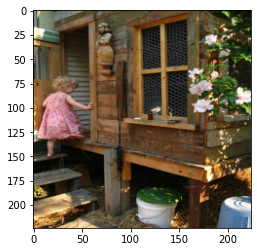

In [31]:
img, caps = flickr_dataset[0]
plt.imshow(img.numpy().transpose((1, 2, 0)))
print("Token:",caps)
print("Sentence:")
print([flickr_dataset.vocab.itos[token] for token in caps.tolist()])

In [39]:
import torch
import torch.nn as nn
from torchvision import models
from torch.autograd import Variable

class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super(Encoder, self).__init__()
        resnet = models.resnet152(pretrained = True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # resnet without the classification fc layer and batchnorm layer
        self.convs =  nn.Sequential(*list(resnet.children())[:-1])
        
        # resnet to embedding size
        self.linear = nn.Linear(resnet.fc.in_features, embedding_size)
        # batch norm the output
        self.bn = nn.BatchNorm1d(embedding_size)
        
        # initialize the weights
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)
        

    def forward(self, images):
        conv_out = self.convs(images)
        
        # reduce to 1d
        features = Variable(conv_out.data)
        features = features.view(features.size(0), -1)
        out = self.bn(self.linear(features))
        return out

In [52]:
encoder = Encoder(300)
encoder.eval()

Encoder(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

In [55]:
encoder_out = encoder.forward(img[None, :])

In [56]:
encoder_out.size()

torch.Size([1, 300])

In [76]:
MAX_CAPTION_LENGTH = 20

class Decoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab, n_layers = 2):
        super(Decoder, self).__init__()        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(self.vocab),embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, len(self.vocab))

        
        
        #self.embedding.weight.data.uniform_(-0.1, 0.1)
        #self.linear.weight.data.uniform_(-0.1, 0.1)
        #self.linear.bias.data.fill_(0)
    


        
    def forward(self, x, captions = None):
        """Decode image feature vectors and generates captions."""
        
        # training 
        if captions is not None:
            embeddings = self.embedding(captions)

            # teacher forcing
            inputs = torch.cat((x.unsqueeze(1), embeddings), 1)
            hiddens, _ = self.lstm(inputs)
            outputs = self.linear(hiddens[0])
            return outputs
        
        # testing/output:
        else:
            caption_out = []
            inputs = x.unsqueeze(1)
            states = None
            # recurrently generated caption words from previous state
            for i in range(MAX_CAPTION_LENGTH):                
                hiddens, states = self.lstm(inputs, states)        # (batch_size, 1, hidden_size), 
                outputs = self.linear(hiddens.squeeze(1))          # (batch_size, vocab_size)
                
                # sample output
                pred = outputs.max(1)[1]
                caption_out.append(pred)
                
                inputs = self.embedding(pred)
                inputs = inputs.unsqueeze(1)                       # (batch_size, 1, embedding_size)
                
                
            return torch.Tensor(caption_out)

In [77]:
decoder = Decoder(300, 200, flickr_dataset.vocab)

In [80]:
decoder_out = decoder(encoder_out)

In [82]:
[flickr_dataset.vocab.itos[token] for token in decoder_out.numpy()]

['plants',
 'acting',
 'acting',
 'sharing',
 'sharing',
 'single',
 'trunks',
 'trunks',
 'wrestling',
 'pauses',
 'pauses',
 'rock',
 'profile',
 'headed',
 'birds',
 'dollar',
 'dollar',
 'pauses',
 'backwards',
 'trunks']